In [55]:
from sentence_transformers import CrossEncoder, InputExample
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from typing import Tuple

In [56]:
def load_data(path: str = "data/preprocessed.feather") -> Tuple[InputExample, InputExample, InputExample]:
    ds = pd.read_feather(path)
    ds.score /= 5
    data = [InputExample(texts=[s1, s2], label=score)
            for s1, s2, score in ds.loc[:, ["sen1", "sen2", "score"]].values]
    train, test = train_test_split(data, train_size=.9, random_state=0)
    train, valid = train_test_split(train, train_size=.8, random_state=0)
    return train, valid, test

train, valid, test = load_data("../data/preprocessed.feather")
sentences, scores = [], []
for inp in test:
    sentences.append(inp.texts)
    scores.append(inp.label)

In [57]:
model_name = "cross-encoder/stsb-roberta-large"
model_path = f"../models/{model_name}/"

model = CrossEncoder(model_path)

In [58]:
predictions = model.predict(sentences, convert_to_numpy=True)
print(f"Pearson correlation: {np.corrcoef(predictions, scores)[0,1]: .4f}")

Pearson correlation:  0.9270


In [59]:
df = pd.DataFrame(data={
    "sen1": [s[0] for s in sentences],
    "sen2": [s[1] for s in sentences],
    "scores": scores,
    "preds": predictions,
    "mae": np.abs(predictions-scores)
})
df.scores *= 5
df.preds *= 5

In [60]:
df = df.sort_values(by="mae", ascending=False)
df.head(10)

,sen1,sen2,scores,preds,mae
2,the act of substituting one thing for another,the act of contacting one thing with another.,0.80,3.439194,0.527839
158,geography as defined by its use.,a district that has been developed to serve so...,2.40,0.047054,0.470589
224,"intuitions, a hunch or feeling","maintain (a theory, thoughts, or feelings).",1.40,3.727419,0.465484
358,an agent or entity becomes sufficient enough t...,fill or meet a want or need,1.20,3.319784,0.423957
347,the act of substituting one thing for another,the act of adding one thing to another.,1.40,3.413820,0.402764
285,Cause to move forward with force.,vary or move from a fixed point or course.,3.80,1.819857,0.396029
307,an open motorboat used for transport,a motorboat with an open deck or a half deck.,2.25,4.097942,0.369588
83,"the reduction of the extent of something, e.g,...",change toward something smaller or lower.,4.40,2.582368,0.363526
301,Generalise the structure of an optimal solutio...,Use these optimal solutions to construct an op...,1.00,2.702164,0.340433
0,(cause to) appear suddenly or briefly,break open or apart suddenly and forcefully.,0.40,2.075112,0.335022


In [61]:
def to_latex(df: pd.DataFrame):
    inner = ""
    for idx, row in df.iterrows():
        inner += "\t" + row.sen1.replace('&', '\&') + " & " + row.sen2.replace('&', '\&') + f" & {row.scores: .2f} & {row.preds: .2f}\\\\\n\t\hline\n"
    outer = ("\\begin{tabular}{|m{5cm}|m{5cm}|m{1.45cm}|m{1.45cm}|}\n"
             "    \hline\n"
             "    Sentence1 & Sentence2 & Score & Prediction \\\\\n"
             "    \hline\hline\n"
             f"{inner}"
             "\end{tabular}\n")
    print(outer)

to_latex(df.head(10))

\begin{tabular}{|m{5cm}|m{5cm}|m{1.45cm}|m{1.45cm}|}
    \hline
    Sentence1 & Sentence2 & Score & Prediction \\
    \hline\hline
	the act of substituting one thing for another & the act of contacting one thing with another. &  0.80 &  3.44\\
	\hline
	geography as defined by its use. & a district that has been developed to serve some purpose; &  2.40 &  0.05\\
	\hline
	intuitions, a hunch or feeling & maintain (a theory, thoughts, or feelings). &  1.40 &  3.73\\
	\hline
	an agent or entity becomes sufficient enough to meet a standard. alternatively, an action or occurrence can be thought of as event that fulfills a standard. in this frame, the agent, entity, or event can be conceptualized as being on a scale where a change of value or circumstances brings it in line with the position of the standard on the scale. & fill or meet a want or need &  1.20 &  3.32\\
	\hline
	the act of substituting one thing for another & the act of adding one thing to another. &  1.40 &  3.41\\
	\hline
	Ca

import numpy as np
import matplotlib.pyplot as plt

np.linspace(0, 5, 100)
plt.plot(xs, func(xs), label="Test Scores", linestyle="dotted")
plt.plot(xs, func(xs), label="Train Scores", linestyle="dotted")
plt.plot(xs, func(xs), label="Validation Scores", linestyle="dotted")
plt.plot(xs, func(xs), label="Predictions", linewidth=1.5)
plt.title("Score Distributions of Labels and Predictions")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()


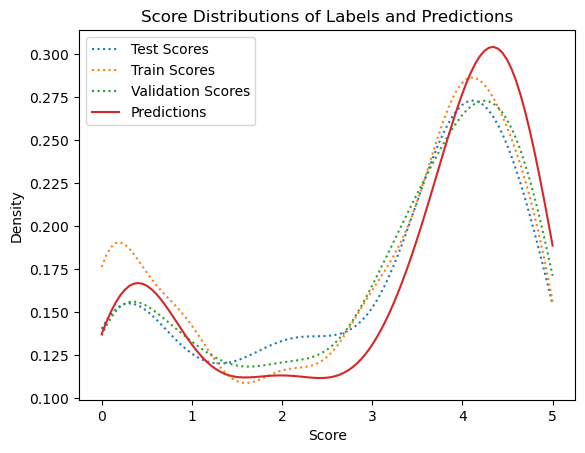

In [64]:
from utx import plot
from scipy.stats import gaussian_kde

ls = "dotted"
print(
    plot(0,5,100)
    .function(gaussian_kde(df.scores), "Test Scores", linestyle=ls)
    .function(gaussian_kde([ex.label*5 for ex in train]), "Train Scores", linestyle=ls)
    .function(gaussian_kde([ex.label*5 for ex in valid]), "Validation Scores", linestyle=ls)
    .function(gaussian_kde(df.preds), "Predictions", linewidth=1.5)
    .labels("Score Distributions of Labels and Predictions", "Score", "Density")
    .legend()
    .export()
)

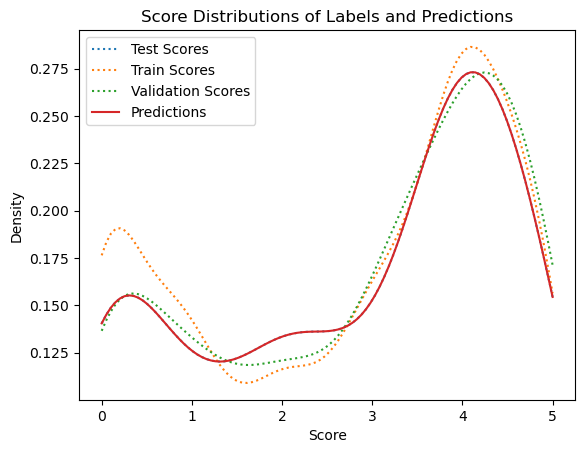

In [69]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def comp_kde(ds: List[InputExample], xs: np.ndarray):
    kde = stats.gaussian_kde([ex.label*5 for ex in ds])
    return [kde(x) for x in xs]

xs = np.linspace(0, 5, 100)
score_kde = stats.gaussian_kde(df.scores)
plt.plot(xs, [score_kde(x) for x in xs],
         label="Test Scores", linestyle="dotted")
plt.plot(xs, comp_kde(train, xs),
         label="Train Scores", linestyle="dotted")
plt.plot(xs, comp_kde(valid, xs),
         label="Validation Scores", linestyle="dotted")
plt.plot(xs, comp_kde(test, xs),
         label="Predictions", linewidth=1.5)
plt.title("Score Distributions of Labels and Predictions")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()

<Axes: xlabel='epoch'>

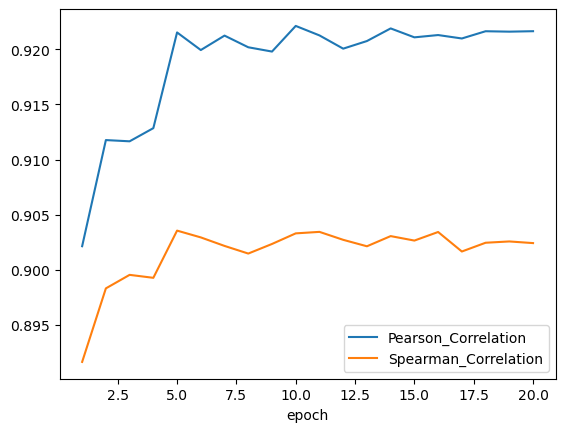

In [63]:
corr = pd.read_csv(f"{model_path}CECorrelationEvaluator_corr-valid_results.csv")
corr.epoch += 1
corr.plot(x="epoch", y=["Pearson_Correlation", "Spearman_Correlation"])